In [1]:
import nemo
from nemo.utils.lr_policies import get_lr_policy
import nemo_nlp
from nemo_nlp.utils.callbacks.sentence_classification import \
    eval_iter_callback, eval_epochs_done_callback
import preproc_data_layer
from pytorch_transformers import BertTokenizer
import torch.nn.functional as f

import math
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = -1

import json

from preproc_data_layer import BertSentenceClassificationDataset, PreprocBertSentenceClassificationDataLayer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")


In [2]:
%matplotlib inline

## Data Explore

The SST-2 dataset https://nlp.stanford.edu/sentiment/index.html is a standard benchmark for sentence classification and is part of the GLUE Benchmark: https://gluebenchmark.com/tasks.

In [3]:
!sh get_data.sh

data directory already exists
SST-2.zip already exists


In [4]:
data_dir = 'data/SST-2'
df = pd.read_csv(data_dir + '/train.tsv', sep='\t')
test_df = pd.read_csv(data_dir + '/test.tsv', sep='\t')

In [5]:
df.head()

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0


In [6]:
test_df

,index,sentence
0,0,uneasy mishmash of styles and genres .
1,1,this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .
2,2,"by the end of no such thing the audience , like beatrice , has a watchful affection for the monster ."
3,3,director rob marshall went out gunning to make a great one .
4,4,"lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new ."
...,...,...
1816,1816,"it risks seeming slow and pretentious , because it thinks the gamble is worth the promise ."
1817,1817,take care of my cat offers a refreshingly different slice of asian cinema .
1818,1818,davis has filled out his cast with appealing fresh faces .
1819,1819,"it represents better-than-average movie-making that does n't demand a dumb , distracted audience ."


The dataset comes with a train file (labeled) and a test file (not labeled).  We will use part of the train file for model validation

In [7]:
# Split train to train and val and save to disk
np.random.seed(123)
train_mask = np.random.rand((len(df))) < .8
train_df = df[train_mask]
val_df = df[~train_mask]

In order to take advantage of NeMo's pre-built sentence classification data layer, the data must formatted as "sentence\tlabel" (sentence tab label).

In [8]:
# We will add a label column with all 0's (but they will not be used for anything).
test_df['label'] = 0

In [9]:
test_df = test_df[['sentence', 'label']]

In [10]:
test_df.head()

,sentence,label
0,uneasy mishmash of styles and genres .,0
1,this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .,0
2,"by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .",0
3,director rob marshall went out gunning to make a great one .,0
4,"lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .",0


In [11]:
# Save new train, val, and test to disk
train_df.to_csv(data_dir + '/my_train.tsv', sep='\t', index=False)
val_df.to_csv(data_dir + '/my_val.tsv', sep='\t', index=False)
test_df.to_csv(data_dir + '/my_test.tsv', sep='\t', index=False)

# Data Preprocessing

In order to use BERT or any other Deep NLP based model, we must first tokenize the data. Our tokenizer will map each word to an integer.

In [12]:
# Each pretrained BERT model comes with a Tokenizer
pretrained_bert_model = 'bert-base-uncased'
#pretrained_bert_model = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_bert_model)

In [13]:
max_seq_length = 64 # we will pad 0's to shorter sentences and truncate longer
sample_dataset = BertSentenceClassificationDataset(
data_dir + '/my_train.tsv',
max_seq_length,
tokenizer,
num_samples=100,
shuffle=False)

In [14]:
def print_tokenization(tokenizer, tokens):
    pad_counter = 0
    for token in tokens:
        if token == 0:
            pad_counter += 1
        if pad_counter > 4:
            break
        vocab_str = list(tokenizer.vocab.keys())[list(tokenizer.vocab.values()).index(token)]
        print(f'{vocab_str:15s} | {token}')

In [15]:
sample_idx = np.random.randint(0, len(sample_dataset))
tokens = sample_dataset[sample_idx][0]
print_tokenization(tokenizer, tokens)

[CLS]           | 101
easily          | 4089
the             | 1996
most            | 2087
thoughtful      | 16465
fictional       | 7214
examination     | 7749
[SEP]           | 102
[PAD]           | 0
[PAD]           | 0
[PAD]           | 0
[PAD]           | 0


We can gain a lot of efficiency by saving the tokenized data to disk. For future model runs we then don't need to tokenize every time.

In [16]:
!python preproc_data.py \
--input_file $f'{data_dir}/my_train.tsv' \
--output_dir $f'{data_dir}/preproc' \
--dataset_name 'train-sst-2' \
--max_seq_length $max_seq_length \
--pretrained_bert_model $pretrained_bert_model

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")


In [17]:
!python preproc_data.py \
--input_file $f'{data_dir}/my_test.tsv' \
--output_dir $f'{data_dir}/preproc' \
--dataset_name "test-sst-2" \
--max_seq_length $max_seq_length \
--pretrained_bert_model $pretrained_bert_model

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")


In [18]:
!python preproc_data.py \
--input_file $f'{data_dir}/my_val.tsv' \
--output_dir $f'{data_dir}/preproc' \
--dataset_name "val-sst-2" \
--max_seq_length $max_seq_length \
--pretrained_bert_model $pretrained_bert_model

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")


## Neural Modules

In NeMo, everything is a Neural Module. Neural modules abstract data and neural network architectures. Where a deep learning framework like PyTorch or Tensorflow is used to combine neural network layers to create a neural network, NeMo is used to combine data and neural networks to create AI applications.

The Neural Module Factory will then manage the neural modules, taking care to flow data through the neural modules, and is also responsible for training (including mixed precision and distributed), logging, and inference.

In [19]:
# instantiate the neural module factory
log_dir = 'logs_' + pretrained_bert_model
checkpoint_dir = 'checkpoints_' + pretrained_bert_model
tensorboard_dir = 'tensorboard_' + pretrained_bert_model
nf = nemo.core.NeuralModuleFactory(log_dir=log_dir,
                                   checkpoint_dir=checkpoint_dir,
                                   tensorboard_dir=tensorboard_dir,
                                   create_tb_writer=True,
                                   add_time_to_log_dir=False,
                                   optimization_level='O1')

Pre-trained models will be automatically downloaded and cached.

In [20]:
# Pre-trained BERT
bert = nemo_nlp.BERT(pretrained_model_name=pretrained_bert_model)

2020-01-17 05:45:38,485 - INFO - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/pytorch_transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
2020-01-17 05:45:38,487 - INFO - Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

2020-01-17 05:45:39,029 - INFO - loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin from cache a

In [21]:
# same bert model config for later use
bert_config_dict = bert.config.to_dict()

bert_model_config_path = pretrained_bert_model + '_config.json'
with open(bert_model_config_path, 'w+') as json_file:
    json.dump(bert_config_dict, json_file)

Note here that the BERT models we are working with are massive. This gives our models a large capacity for learning that is needed to understand the nuance and complexity of natural language.

In [22]:
print(f'{pretrained_bert_model} has {bert.num_weights} weights')

bert-base-uncased has 109482240 weights


Here we define and instantiate the feed forward network that takes as input our BERT embeddings. This network will be used to output the sentence classifications.

In [23]:
# mlp classifier
bert_hidden_size = bert.local_parameters['hidden_size']

mlp = nemo_nlp.SequenceClassifier(hidden_size=bert_hidden_size, 
                                  num_classes=2,
                                  num_layers=2,
                                  log_softmax=False,
                                  dropout=0.1)

loss = nemo.backends.pytorch.common.CrossEntropyLoss()

In [24]:
# Compared to the BERT model, the MLP is tiny.
print(f'MLP has {mlp.num_weights} weights')

MLP has 592130 weights


# Pipelines

Pipelines are used to define how data will flow the different neural networks. In this case, our data will flow through the BERT network and then the MLP network.

We also have different pipelines for training, validation, and inference data.  

For training data, we want it to be used for optimization so it must be shuffled and we also need to compute the loss.

For validation data, we won't use it for optimization but we want to know the loss.

And for inference data, we only want the final predictions coming from the model.

## Data Layers

In [25]:
use_preproc = True

if pretrained_bert_model == 'bert-base-uncased':
    batch_size = 256
if pretrained_bert_model == 'bert-large-uncased':
    batch_size = 64

if use_preproc:
    train_data = preproc_data_layer.PreprocBertSentenceClassificationDataLayer(
        input_file=f'{data_dir}/preproc/train-sst-2_{pretrained_bert_model}_{max_seq_length}.hdf5',
        shuffle=True,
        num_samples=-1, # lower for dev, -1 for all dataset
        batch_size=batch_size
    )
    val_data = preproc_data_layer.PreprocBertSentenceClassificationDataLayer(
        input_file=f'{data_dir}/preproc/val-sst-2_{pretrained_bert_model}_{max_seq_length}.hdf5',
        shuffle=False,
        num_samples=-1, # lower for dev, -1 for all dataset
        batch_size=batch_size
    )
else:
    train_data = preproc_data_layer.BertSentenceClassificationDataLayer(
        input_file=data_dir + '/my_train.tsv',
        tokenizer=tokenizer,
        max_seq_length=max_seq_length,
        shuffle=True,
        num_samples=-1, # lower for dev, -1 for all dataset
        batch_size=batch_size
    )
    val_data = preproc_data_layer.BertSentenceClassificationDataLayer(
        input_file=data_dir + '/my_val.tsv',
        tokenizer=tokenizer,
        max_seq_length=max_seq_length,
        shuffle=False,
        num_samples=-1, # lower for dev, -1 for all dataset
        batch_size=batch_size
    )

In [26]:
train_input, train_token_types, train_attn_mask, train_labels = train_data()
val_input, val_token_types, val_attn_mask, val_labels = val_data()

## BERT Embeddings

In [27]:
train_embeddings = bert(input_ids=train_input,
                        token_type_ids=train_token_types,
                        attention_mask=train_attn_mask)
val_embeddings = bert(input_ids=val_input,
                        token_type_ids=val_token_types,
                        attention_mask=val_attn_mask)

## Inspect BERT Embeddings

If we want to inspect the data as it flows through our neural factory we can use the .infer method.  This method will give us the tensors without performing any optimization.

In [28]:
val_input_tensors = nf.infer(tensors=[val_input])

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


2020-01-17 05:45:45,904 - INFO - Evaluating batch 0 out of 53
2020-01-17 05:45:45,912 - INFO - Evaluating batch 5 out of 53
2020-01-17 05:45:46,111 - INFO - Evaluating batch 10 out of 53
2020-01-17 05:45:46,116 - INFO - Evaluating batch 15 out of 53
2020-01-17 05:45:46,120 - INFO - Evaluating batch 20 out of 53
2020-01-17 05:45:46,124 - INFO - Evaluating batch 25 out of 53
2020-01-17 05:45:46,128 - INFO - Evaluating batch 30 out of 53
2020-01-17 05:45:46,132 - INFO - Evaluating batch 35 out of 53
2020-01-17 05:45:46,137 - INFO - Evaluating batch 40 out of 53
2020-01-17 05:45:46,141 - INFO - Evaluating batch 45 out of 53
2020-01-17 05:45:46,149 - INFO - Evaluating batch 50 out of 53


In [29]:
print(val_input_tensors[0][0][0].shape)

torch.Size([64])


In [30]:
print(val_input_tensors[0][0][0])

tensor([  101, 16691,  2008,  1996,  2472,  1997,  2107,  5365, 27858,  2015,
         2004, 16419,  2399,  2064,  2145,  2735,  2041,  1037,  2235,  1010,
         3167,  2143,  2007,  2019,  6832,  2813,  7361,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [31]:
%%time
val_embeddings_tensors = nf.infer(tensors=[val_embeddings])

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


2020-01-17 05:45:47,593 - INFO - Evaluating batch 0 out of 53
2020-01-17 05:45:48,810 - INFO - Evaluating batch 5 out of 53
2020-01-17 05:45:49,535 - INFO - Evaluating batch 10 out of 53
2020-01-17 05:45:50,144 - INFO - Evaluating batch 15 out of 53
2020-01-17 05:45:50,774 - INFO - Evaluating batch 20 out of 53
2020-01-17 05:45:51,385 - INFO - Evaluating batch 25 out of 53
2020-01-17 05:45:51,994 - INFO - Evaluating batch 30 out of 53
2020-01-17 05:45:52,603 - INFO - Evaluating batch 35 out of 53
2020-01-17 05:45:53,216 - INFO - Evaluating batch 40 out of 53
2020-01-17 05:45:53,826 - INFO - Evaluating batch 45 out of 53
2020-01-17 05:45:54,439 - INFO - Evaluating batch 50 out of 53


CPU times: user 5.02 s, sys: 3.23 s, total: 8.25 s
Wall time: 8.58 s


In [32]:
# each word is embedded into bert_hidden_size space
# max_seq_len words are embedded
print(val_embeddings_tensors[0][0][0].shape)

torch.Size([64, 768])


In [33]:
val_embeddings_tensors[0][0].shape

torch.Size([256, 64, 768])

In [34]:
val_embeddings_tensors[0][0][0][:].shape

torch.Size([64, 768])

In [35]:
print(val_embeddings_tensors[0][0][1][:, 0])

tensor([-0.0411,  0.3524, -0.0902,  0.4333,  0.1844, -0.1057,  0.1166,  1.0779,
         1.6076,  0.7321, -0.0281,  0.3880, -0.1483,  0.2836,  0.1240,  0.3311,
        -0.0743,  0.9674,  0.6252,  1.8747,  0.2040, -0.8777,  1.2994,  0.1390,
         0.1290,  0.8688,  0.6109,  0.6801,  0.8891,  0.3688,  0.5610,  0.3336,
         0.6595,  0.5202,  0.2784,  0.2691,  0.2921,  0.5695,  0.6469,  0.6729,
         0.3354, -0.0220, -0.0829,  0.2345,  0.0615,  0.3287,  0.3376,  0.3226,
         0.0716, -0.1945,  0.4177, -0.0321,  0.1759,  0.5043,  0.0893,  0.5966,
         0.7837,  0.8568,  0.3591,  0.2225,  0.2630,  0.1896,  0.2109,  0.4541])


## Understanding and Visualizing BERT Embeddings

We are going to look at the BERT embeddings for the words (1-word sentences) in "data/SST-2/positive_negative.tsv". Since the BERT embeddings are 768 dimensional for BERT base and 1024 dimensional for BERT large, we'll first apply TSNE and reduce the embeddings to two dimensions.

In [36]:
spectrum_df = pd.read_csv(data_dir + '/positive_negative.tsv', delimiter='\t')
print(spectrum_df.sentence.values)

['abysmal' 'apalling' 'dreadful' 'awful' 'terrible' 'very bad'
 'really bad' 'rubbish' 'unsatisfactory' 'bad' 'poor' 'great'
 'really good' 'very good' 'awesome' 'fantastic' 'superb' 'brilliant'
 'incredible' 'excellent' 'outstanding' 'perfect']


In [37]:
# positive negative spectrum
spectrum_data = nemo_nlp.BertSentenceClassificationDataLayer(
    input_file=data_dir + '/positive_negative.tsv',
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    shuffle=False,
    num_samples=-1, # lower for dev, -1 for all dataset
    batch_size=batch_size,
    dataset_type=preproc_data_layer.BertSentenceClassificationDataset
)

2020-01-17 05:45:54,916 - INFO - data/SST-2/positive_negative.tsv: 22
2020-01-17 05:45:54,920 - INFO - Min: 3 |                  Max: 6 |                  Mean: 3.5 |                  Median: 3.0
2020-01-17 05:45:54,921 - INFO - 75 percentile: 4.0
2020-01-17 05:45:54,923 - INFO - 99 percentile: 5.789999999999999
2020-01-17 05:45:54,924 - INFO - 0 out of 22                        sentencess with more than 64 subtokens.
2020-01-17 05:45:54,925 - INFO - *** Example ***
2020-01-17 05:45:54,925 - INFO - example_index: 0
2020-01-17 05:45:54,927 - INFO - subtokens: [CLS] ab ##ys ##mal [SEP]
2020-01-17 05:45:54,928 - INFO - sent_label: 0
2020-01-17 05:45:54,929 - INFO - input_ids: 101 11113 7274 9067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2020-01-17 05:45:54,930 - INFO - input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [38]:
spectrum_input, spectrum_token_types, spectrum_attn_mask, spectrum_labels = spectrum_data()

In [39]:
spectrum_embeddings = bert(input_ids=spectrum_input,
                        token_type_ids=spectrum_token_types,
                        attention_mask=spectrum_attn_mask)

In [40]:
spectrum_embeddings_tensors = nf.infer(tensors=[spectrum_embeddings])

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


2020-01-17 05:45:57,213 - INFO - Evaluating batch 0 out of 1


In [41]:
spectrum_embeddings_tensors[0][0].shape

torch.Size([22, 64, 768])

In [42]:
spectrum_embeddings_tensors[0][0][:,0,:].shape

torch.Size([22, 768])

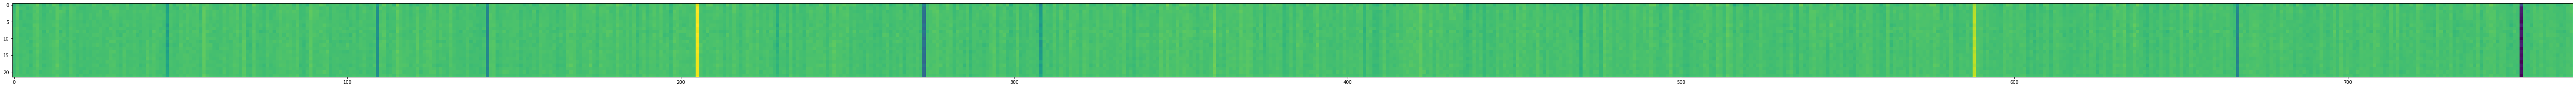

In [43]:
plt.figure(figsize=(100,100))
plt.imshow(spectrum_embeddings_tensors[0][0][:,0,:].numpy())

[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.001s...
[t-SNE] Computed neighbors for 22 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1.952878
[t-SNE] KL divergence after 100 iterations with early exaggeration: 36.743279
[t-SNE] KL divergence after 1000 iterations: 0.099344


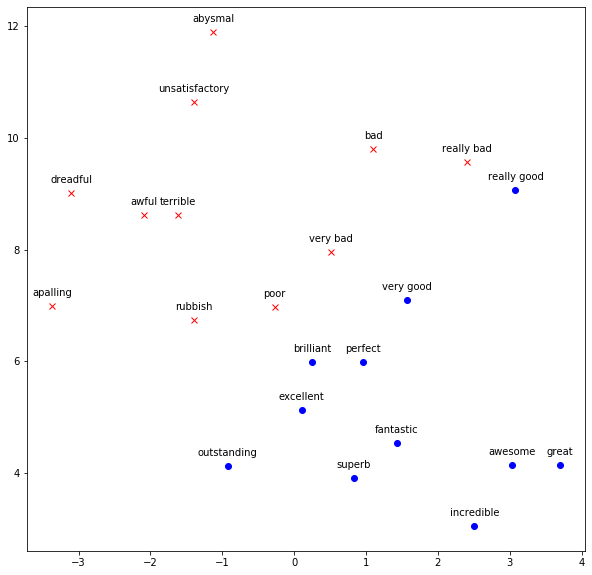

In [44]:

spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:11, 0], tsne_spectrum[0:11, 1], 'rx')
plt.plot(tsne_spectrum[11:, 0], tsne_spectrum[11:, 1], 'bo')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## Training Pipeline 

In order to optimize our network, we need to pass the embeddings through the MLP network and then compute the loss.

In [45]:
train_logits = mlp(hidden_states=train_embeddings)
val_logits = mlp(hidden_states=val_embeddings)

train_loss = loss(logits=train_logits, labels=train_labels)
val_loss = loss(logits=val_logits, labels=val_labels)

## Callbacks

Callbacks are used to record and log metrics and save checkpoints for the training and evaluation. We use callbacks to print to screen and also to tensorboard.




In [46]:
num_epochs = 3

num_gpus = 1

train_data_size = len(train_data)

steps_per_epoch = math.ceil(train_data_size / (batch_size * num_gpus))

train_callback = nemo.core.SimpleLossLoggerCallback(
    tensors=[train_loss, train_logits],
    print_func=lambda x: nf.logger.info(f'Train loss: {str(np.round(x[0].item(), 3))}'),
    tb_writer=nf.tb_writer,
    get_tb_values=lambda x: [["train_loss", x[0]]],
    step_freq=1)

eval_callback = nemo.core.EvaluatorCallback(
    eval_tensors=[val_logits, val_labels],
    user_iter_callback=lambda x, y: eval_iter_callback(
        x, y, val_data),
    user_epochs_done_callback=lambda x: eval_epochs_done_callback(
        x, f'{nf.work_dir}/graphs'),
    tb_writer=nf.tb_writer,
    eval_epoch=1,
    eval_step=steps_per_epoch)

# Create callback to save checkpoints
ckpt_callback = nemo.core.CheckpointCallback(
    folder=nf.checkpoint_dir,
    epoch_freq=1,
    step_freq=-1,
    checkpoints_to_keep=num_epochs)

In [47]:
lr_policy_fn = get_lr_policy('WarmupAnnealing',
                             total_steps=num_epochs * steps_per_epoch,
                             warmup_ratio=0.1)

2020-01-17 05:46:19,991 - WARNING - Data Layer does not have any weights to return. This get_weights call returns None.
2020-01-17 05:46:20,005 - INFO - Starting .....
2020-01-17 05:46:20,010 - INFO - Found 2 modules with weights:
2020-01-17 05:46:20,011 - INFO - BERT
2020-01-17 05:46:20,012 - INFO - SequenceClassifier
2020-01-17 05:46:20,015 - INFO - Total model parameters: 110074370
2020-01-17 05:46:20,016 - INFO - Restoring checkpoint from folder checkpoints_bert-base-uncased ...


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


2020-01-17 05:46:21,319 - INFO - Done in 1.3121953010559082
2020-01-17 05:46:21,320 - INFO - Final Evaluation ..............................
2020-01-17 05:46:31,989 - INFO - Accuracy: 0.9524977698483497
2020-01-17 05:46:31,991 - INFO - Sampled preds: [1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0]
2020-01-17 05:46:31,992 - INFO - Sampled labels: [1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0]
2020-01-17 05:46:32,218 - INFO -               precision    recall  f1-score   support

           0       0.95      0.94      0.95      5950
           1       0.95      0.96      0.96      7502

    accuracy                           0.95     13452
   macro avg       0.95      0.95      0.95     13452
weighted avg       0.95      0.95      0.95     13452

2020-01-17 05:46:32,220 - INFO - Evaluation time: 10.898316621780396 seconds
2020-01-17 05:46:36,614 - INFO - Saved checkpoint: checkpoints_bert-base-uncased/trainer-EPOCH-3.pt


CPU times: user 7.74 s, sys: 6.52 s, total: 14.3 s
Wall time: 16.6 s


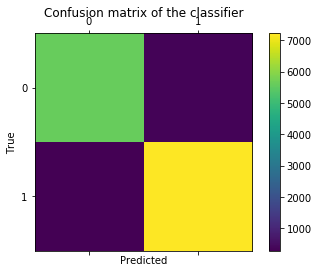

In [48]:
%%time
nf.train(tensors_to_optimize=[train_loss],
         callbacks=[train_callback, eval_callback, ckpt_callback],
         lr_policy=lr_policy_fn,
         optimizer='adam',
         optimization_params={'num_epochs': num_epochs, 'lr': 5e-5})

In [49]:
print(tensorboard_dir)

tensorboard_bert-base-uncased


In [51]:
# # command for distributed training
# time python -m torch.distributed.launch --nproc_per_node=2 sentence_classification.py \
# --train_file $f'{data_dir}/preproc/train-sst-2_{pretrained_bert_model}_{max_seq_length}.hdf5' \
# --eval_file $f'{data_dir}/preproc/train-sst-2_{pretrained_bert_model}_{max_seq_length}.hdf5' \
# --num_gpus 2 \
# --batch_size $batch_size \
# --amp_opt_level O1 \
# --work_dir $f'distributed_logs_{pretrained_bert_model}' \
# --mode train \
# --num_classes 2 \
# --num_samples -1 \
# --num_epochs 1 \
# --preproc